## Otimização dos parâmetros de um MOT

Como demonstração da capacidade do método de otimização por processo gaussiano aplicado pelo M-LOOP de lidar com os fênomenos envolvidos no funcionamento de um MOT, vamos tomar a tarefa mais simples de otimizar resultados que vêm direto de nossos modelos teóricos.

De modo mais claro, o papel de experimento será feito por uma curta sessão de código que recebe os parâmetros otimizados e retorna como custo o valor da grandeza sendo otimizada para esses parâmetros, de acordo com um modelo. O custo em si pode não ser o resultado direto do modelo, que podemos, e devemos, manipular de modo a garantir que o ponto ótimo procurado corresponda a um mínimo de custo.

#### Parâmetros

Para testar o método, simularemos a força sentida por átomo de rubídio-87 dentro de um MOT típico. Definimos nossso parâmetros abaixo.

| Parâmetro | Valor | Definição |
| :---: |:---:| :---: |
| ```decay_rate```            |  | Taxa de decaimento da população excitada. |
| ```transition_wavelength``` |  | Comprimento de onda da transição utilizada para o resfriamento. |

In [3]:
excited_state_decay_rate = 37*10**6

In [4]:
transition_wavelength = 780*10**-9
transition_frequency = 1/transition_wavelength

#### Código

Vamos implementar o M-LOOP em um experimento completamente controlado por um scrip Python, como uma biblioteca. Começamos importanto então os três módulos essenciais da biblioteca ```mloop```: 
* ```mloop.interfaces``` realiza a conexão entre o otimizador e o experimento, possibilitando que o otimizador controle a execução deste.
* ```mloop.controllers``` controla a realização dos ciclos de experimentação e otimização dos parâmetros por meio da interface, de acordo com um conjunto de configurações.
* ```mloop.visualizations``` prepara um conjunto de visualizações padrão do processo de otimização e a forma do modelo final.

In [5]:
import mloop.interfaces as mli
import mloop.controllers as mlc
import mloop.visualizations as mlv

/home/lucasdsa/anaconda3/lib/python3.7/site-packages/tensorflow-2.0.0b1-py3.7-linux-x86_64.egg/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/tensorflow-2.0.0b1-py3.7-linux-x86_64.egg/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/tensorflow-2.0.0b1-py3.7-linux-x86_64.egg/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 

Outras bibliotecas úteis

In [6]:
import numpy as np
from scipy import constants
import cProfile
import pstats
from pstats import SortKey

#### Interface

A implementação do M-LOOP como uma biblioteca em um experimento controlado por Python nos permite grande flexibilidade quanto a como ocorre a interação entre o experimento e o M-LOOP, por meio da função de custo. 

A interface é implementada por meio de uma subclasse da classe ```Interface```, que por sua vez é parte do módulo ```mloop.interfaces```. Além de herdar os métodos de ```Interface```, nossa classe de interface deve possuir um método ```get_next_cost_dict```, responsável por chamar a execução do experimento com os melhores parâmetros da última versão do modelo ajustado e então retornar para o otimizador o custo relacionado aos parâmetros. 

$$\mathbf{F}_\pm = \pm \frac{h\gamma}{2} \frac{s_0}{1+s_0+(2\delta_\pm/\gamma)^2} \mathbf{k}$$
$$\delta_\pm = \delta \mp \mathbf{k}\cdot\mathbf{v} \pm \mu^\prime B/\hbar, \;\;\; \mu^\prime \equiv (g_eM_e-g_gM_g)\mu_B$$
$$B = A\sqrt{\rho^2+4z^2}$$

In [71]:
class MOTexperiment():
    
    def __init__(self, excited_state_decay_rate, transition_frequency):
        self.excited_state_decay_rate = excited_state_decay_rate
        self.transition_frequency = 2*np.pi*transition_frequency
        self.laser_frequency = 0
        self.laser_wavelength = 0
        self.wavevector = 0
        self.field_gradient = 0
        self.saturation_parameter = 0
        
    def _quadrupole_trap_field(self, q):
        rho = np.sqrt(q[0]**2+q[1]**2)
        z = q[2]
        return self.field_gradient*np.sqrt(rho**2+4*z**2)
        
    def _magnetic_field_intensity(self, z):
        return np.dot(np.array([0,0,self.field_gradient*z]),np.array([0,0,1]))
    
    def _detuning(self, q, v, laser_direction):
        "q=0 at the center of the trap"
        frequency_detuning = self.laser_frequency - self.transition_frequency
        doppler_detuning   = -laser_direction*np.dot(self.wavevector,v)
        #magnetic_detuning  = laser_direction*constants.physical_constants['Bohr magneton'][0]*self._quadrupole_trap_field(q)/constants.hbar
        print(frequency_detuning+doppler_detuning, 'total_detuning')
        return frequency_detuning + doppler_detuning
    
    def _mot_force(self,q,v):
        print(self.laser_frequency, 'laser_frequency')
        print(self.transition_frequency, 'transition_frequency')
        positive_force = (constants.hbar*self.wavevector*self.excited_state_decay_rate/2)*(self.saturation_parameter/(1+self.saturation_parameter+(2*self._detuning(q,v,1)/self.excited_state_decay_rate)**2))
        negative_force = -(constants.hbar*self.wavevector*self.excited_state_decay_rate/2)*(self.saturation_parameter/(1+self.saturation_parameter+(2*self._detuning(q,v,-1)/self.excited_state_decay_rate)**2))
        return positive_force+negative_force
        
    def update_settings(self, laser_frequency, saturation_parameter, field_gradient=0):
        self.saturation_parameter = saturation_parameter
        self.laser_frequency = 2*np.pi*laser_frequency*1e6
        #self.field_gradient = field_gradient*1e-2
        self.laser_wavelength = constants.c/(laser_frequency*1e6)
        self.wavevector = np.array([0,0,2*np.pi*laser_frequency*1e6/constants.c])
        return None
    
    def measure_scaled_force_at(self,q,v):
        if self.laser_frequency == 0: 
            print('Please initialize experiment settings by calling update_settings')
        else:
            vec_force = self._mot_force(q,v)/(constants.hbar*np.linalg.norm(self.wavevector)*self.excited_state_decay_rate)
            return -np.linalg.norm(vec_force)

In [93]:
class MOTinterface(mli.Interface):
    
    def __init__(self, experiment, excited_state_decay_rate, transition_frequency):
        super(MOTinterface,self).__init__()
        self.excited_state_decay_rate = excited_state_decay_rate
        self.transition_frequency = transition_frequency*1e-6
        self.experiment = experiment
        self.measurement_position = np.float64(0)
        self.measurement_velocity = np.array([0,0,0])
            
    def set_measurement_coordinates(self,q,v):
        self.measurement_position = q
        self.measurement_velocity = v
        return None

    def get_next_cost_dict(self,params_dict):
        params = params_dict['params']

        laser_frequency = params[0]+self.transition_frequency
        saturation_parameter = params[1]
        #field_gradient = params[2]

        self.experiment.update_settings(laser_frequency, saturation_parameter)

        cost = self.experiment.measure_scaled_force_at(self.measurement_position,self.measurement_velocity)

        noisy_cost = cost+np.random.random()*1e-9
        uncer = 1e-11
        bad = False
    
        cost_dict = {'cost' : noisy_cost, 'uncer' : uncer, 'bad' : bad}
        
        return cost_dict 

#### Controlador

Criada a interface, a inicialização do processo de otimização exige apenas três linhas. Primeiro inicializaremos uma instância da nossa interface com os devidos parâmetros, e então inicializaremos um controlador, do módulo ```mloop.controllers```, que recebe a interface e outro parâmetros de configuração. Por fim, a otimização em si é chamada pelo método ```optimize``` do controlador.

In [94]:
def main():
    """Creates an instance of the MOTinterface class, then
    a controller with that interface and a series of 
    configurations (that can be found in the M-LOOP 
    documentation). Lastly, the optimize() method is called
    to start the process."""
    experiment = MOTexperiment(excited_state_decay_rate,transition_frequency)
    interface = MOTinterface(experiment, excited_state_decay_rate, transition_frequency)
    measurement_position = np.array([0,0,0.003])
    measurement_velocity = np.array([0,0,-55])
    interface.set_measurement_coordinates(measurement_position, measurement_velocity)
    controller = mlc.create_controller(interface,
                                       num_params = 2,
                                       min_boundary = [-4*excited_state_decay_rate*1e-6,0.1],
                                       max_boundary = [4*excited_state_decay_rate*1e-6,10],
                                       first_params = [0,1],
                                       max_num_runs = 200,
                                       cost_has_noise = True,
                                       no_delay = False)
    controller.optimize()
    
    return controller

#### Execução

No ambiente flexível do Jupyter, basta agora que apenas chamemos nossa função ```main()```. Para que possamos tratar das visualizações separadamente, a classe nos retorna o objeto ```controller```, de modo que a partir dele possamos visualizar os resultados quando quisermos.

In [95]:
optimization_profiler = cProfile.Profile()

In [96]:
optimization_profiler.enable()
controller = main()
optimization_profiler.disable()

INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [0. 1.]
8055365.778435366 laser_frequency
8055365.778435366 transition_frequency
1.477839438555673 total_detuning
-1.477839438555673 total_detuning
INFO     cost 9.787717560788331e-10 +/- 1e-11
INFO     Run:2 (training)
INFO     params [88.76576518  1.19121026]
565787117.3482809 laser_frequency
8055365.778435366 transition_frequency
557731855.3692929 total_detuning
557731647.7703983 total_detuning
INFO     cost 4.1370244474281224e-10 +/- 1e-11
INFO     Run:3 (training)
-85704734.82466576 laser_frequency
8055365.778435366 transition_frequency
-93760116.3265134 total_detuning
-93760084.87968884 total_detuning
INFO     params [-14.92238348   9.26825936]
INFO     cost -6.103233253662663e-08 +/- 1e-11
INFO     Run:4 (training)
INFO     params [-142.87876544    8.23390957]
-889678393.9110384 laser_frequency
8055365.778435366 transition_frequency
-897733922.9100964 total_detuning
-897733596.4688511 total_detuning
INFO   

[WARNING/GaussianProcessLearner-20] Parameters provided to Gaussian process learner not in boundaries:array([48.80197367,  0.1       ])


INFO     cost -3.85594954803389e-09 +/- 1e-11
INFO     Run:67 (machine learner)
INFO     params [9.04508976 9.84022628]
64887340.84168638 laser_frequency
8055365.778435366 transition_frequency
56831986.96749894 total_detuning
56831963.159003094 total_detuning
INFO     cost -9.393440376880857e-08 +/- 1e-11
INFO     Run:68 (machine learner)
INFO     params [-62.47530461  10.        ]
-384488550.21096057 laser_frequency
8055365.778435366 transition_frequency
-392543986.52776235 total_detuning
-392543845.4510295 total_detuning
INFO     cost -7.101915311773486e-09 +/- 1e-11
INFO     Run:69 (machine learner)
INFO     params [-81.1786581  10.       ]
-502005186.03956866 laser_frequency
8055365.778435366 transition_frequency
-510060643.91600215 total_detuning
-510060459.72000587 total_detuning
INFO     cost -4.186454062309913e-09 +/- 1e-11
INFO     Run:70 (machine learner)
65889002.16519687 laser_frequency
8055365.778435366 transition_frequency
57833648.47477447 total_detuning
57833624.2987485

[WARNING/GaussianProcessLearner-20] Parameters provided to Gaussian process learner not in boundaries:array([1.24132076e+02, 1.00000000e-01])


INFO     params [103.61341695   7.934328  ]
659077664.7748042 laser_frequency
8055365.778435366 transition_frequency
651022419.9109236 total_detuning
651022178.0818142 total_detuning
INFO     cost -1.916496522478734e-09 +/- 1e-11
INFO     Run:92 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.30089851e-05,  6.69280404e-06, -9.42661833e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


INFO     params [9.04508976 9.84022628]
64887340.84167014 laser_frequency
8055365.778435366 transition_frequency
56831986.9674827 total_detuning
56831963.15898685 total_detuning
INFO     cost -9.40013863563682e-08 +/- 1e-11
INFO     Run:93 (machine learner)
INFO     params [9.04508976 9.84022628]
64887340.84167014 laser_frequency
8055365.778435366 transition_frequency
56831986.9674827 total_detuning
56831963.15898685 total_detuning
INFO     cost -9.43440803243671e-08 +/- 1e-11
INFO     Run:94 (machine learner)
INFO     params [-1.22243234e+02  1.00000000e-01]
-760021523.8428735 laser_frequency
8055365.778435366 transition_frequency
-768077029.0550494 total_detuning
-768076750.1875682 total_detuning
INFO     cost 5.781764157278949e-10 +/- 1e-11
INFO     Run:95 (machine learner)
INFO     params [ 9.2283562 10.       ]
66038837.845318295 laser_frequency
8055365.778435366 transition_frequency
57983484.18238479 total_detuning
57983459.95138107 total_detuning
INFO     cost -9.439950809126323

/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.58253583e-05, -1.97607180e-05, -9.61322968e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


INFO     params [9.24558384 9.99999989]
66147082.33485301 laser_frequency
8055365.778435366 transition_frequency
58091728.691778064 total_detuning
58091704.421057224 total_detuning
INFO     cost -9.402221576713918e-08 +/- 1e-11
INFO     Run:193 (machine learner)
INFO     params [ 9.21292762 10.        ]
65941897.23463293 laser_frequency
8055365.778435366 transition_frequency
57886543.55391467 total_detuning
57886519.35848046 total_detuning
INFO     cost -9.46559209671948e-08 +/- 1e-11
INFO     Run:194 (machine learner)
INFO     params [ 9.20258989 10.        ]
65876943.347599566 laser_frequency
8055365.778435366 transition_frequency
57821589.65496485 total_detuning
57821565.483363554 total_detuning
INFO     cost -9.437677361064693e-08 +/- 1e-11
INFO     Run:195 (machine learner)
INFO     params [ 9.22003924 10.        ]
65986580.844182655 laser_frequency
8055365.778435366 transition_frequency
57931227.17166206 total_detuning
57931202.95983252 total_detuning
INFO     cost -9.40762252230

Adicionar um ruído aleatório e uma incerteza de mesma ordem ao custo parece ter eliminado completamente o problema da geração de variâncias negativas pelo otimizador. "Parece", uma vez que só posso confirmar que nenhuma das execuções após a adição de ruído gerou esse erro, enquanto todas as anteriores geravam; embora isso me faça acreditar que estava certo em minha suspeita de que a artificialidade do custo era a responsável por esse erro (que deveria ser impossível), é claro que não posso afirmar que isso jamais ocorrerá de novo.

Ainda observamos um outro erro, "ABNORMAL_TERMINATION_IN_LNSRCH", mas este se mostrou mais fácil de entender. Como o nome sugere, ele se deve a um problema na busca de linha executada pelo otimizador. Uma pesquisa rápida me levou a esta pergunta no StackOverflow: https://stackoverflow.com/questions/34663539/scipy-optimize-fmin-l-bfgs-b-returns-abnormal-termination-in-lnsrch . A pergunta se refere à recepção do mesmo erro na aplicação do algoritmo L-BFGS-B (esclarecimento abaixo). Checando a documentação do método de Processo Gaussiano do Scikit-Learn (que levanta o erro no nosso caso), verifiquei que esse é mesmo o algortimo padrão dele, então assumirei que é o que o M-LOOP está usando. Nesse caso, a reposta que encontrei pode ser válida: a implementação do L-BFGS-B é escrita em Fortran77, e esse erro é levantado na ocasião de que o código recebe repetidas vezes uma direção de busca na qual a função cresce, enquanto o objetivo dele é minimizá-la. Alternativamente, o otimizador pode estar operando em uma região tão plana da função que erro computacional passa a interferir no processo. Suspeito de que algo desse tipo possa estar ocorrendo em consequência da forma da dependência no gradiente do campo magnético; farei testes quanto a isso.

**L-BFGS**: algoritmo de otimização que aproxima o algoritmo BFGS (Broyden-Fletcher-Goldfarb-Shanno) usando uma quantidade limitada de memória.

**L-BFGS-B**: algoritmo L-BFGS adaptado para vínculos de caixa.

In [87]:
optimization_profiling_stats = pstats.Stats(optimization_profiler)
optimization_profiling_stats.strip_dirs()
optimization_profiling_stats.sort_stats(SortKey.CUMULATIVE)
optimization_profiling_stats.print_stats(10)

         2525648 function calls (2483434 primitive calls) in 84.783 seconds

   Ordered by: cumulative time
   List reduced from 381 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   84.783   42.392 interactiveshell.py:3287(run_code)
        2    0.000    0.000   84.783   42.391 {built-in method builtins.exec}
        1    0.001    0.001   84.783   84.783 <ipython-input-86-f449337a8611>:2(<module>)
        1    0.000    0.000   84.781   84.781 <ipython-input-84-f31e81b88ed8>:1(main)
        1    0.000    0.000   84.428   84.428 controllers.py:310(optimize)
        1    0.007    0.007   78.396   78.396 controllers.py:644(_optimization_routine)
      402    0.007    0.000   65.415    0.163 queues.py:91(get)
      402    0.002    0.000   65.260    0.162 connection.py:208(recv_bytes)
      402    0.003    0.000   65.257    0.162 connection.py:406(_recv_bytes)
      804    0.006    0.000   65.252    0.081 con

In [88]:
#Melhor custo, com incerteza
print(controller.best_cost,'+-',controller.best_uncer)

-3.375385798774061e-09 +- 1e-10


In [89]:
#Detuning, em MHz
controller.best_params[0]

10.298603502550211

In [90]:
#Parâmetro de saturação, adimensional
controller.best_params[1]

10.0

#Gradiente do campo magnético, em G/cm
controller.best_params[2]

#### Visualização

O M-LOOP conta com um módulo dedicado à geração de visualizações padrão, o ```mloop.visualizations```. Basta chamarmos então

INFO     Showing visualizations, close all to end MLOOP.


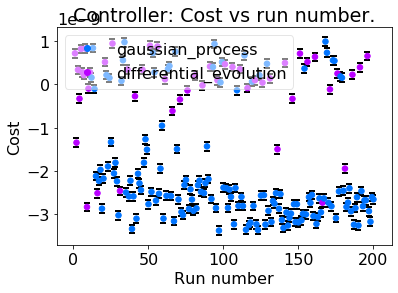

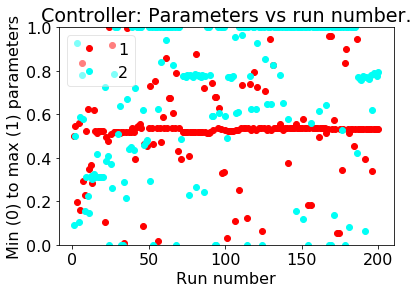

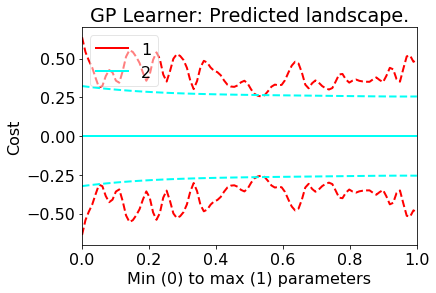

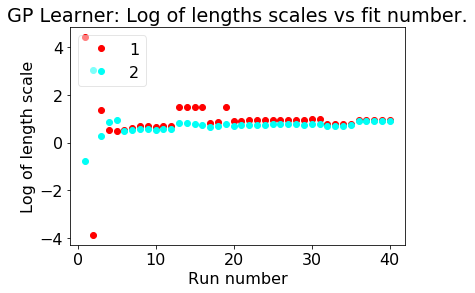

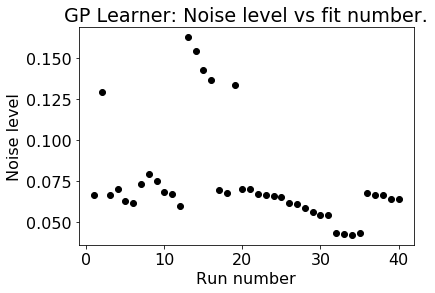

In [91]:
mlv.show_all_default_visualizations(controller)

#### Notas

**200 iterações, ruído de ordem 1e-2, incerteza 1e-3, sem parâmetros iniciais**  
Detuning: -122.31374772332526 MHz  
S: 44.06971804014818  
dB: 78.61146724365268 G/cm
***